In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm
import sys
import matplotlib as mpl

sys.modules.pop('generate_syn_data', None)
from generate_syn_data import *

sys.modules.pop('ARW', None)
from ARW import *

In [ ]:
#take some fixed windows, train predictors using the data from the past windows, and do predictive inference 

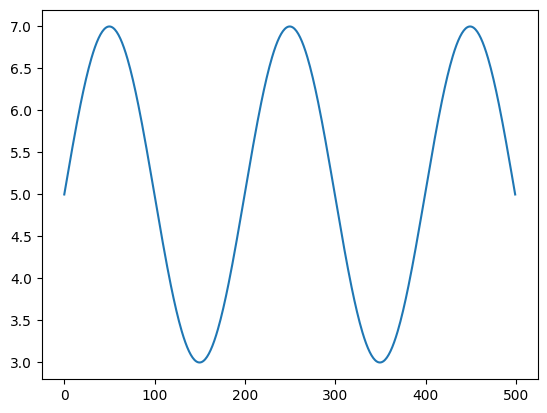

1it [00:40, 40.60s/it]


In [50]:
alpha =0.1; delta = 0.1; gamma=1
num_periods = 500

#NOTE: uncomment to change shift patterns
beta_1 = 2 * np.sin(np.linspace(0, 5*np.pi, num_periods)) + 5
plt.plot(beta_1)
plt.show()

#beta_1 = np.ones(num_periods)
beta_2 = np.ones(num_periods)
beta = np.column_stack((beta_1, beta_2))
variance_y = 0.1; meanX = 1

np.random.seed(6)

#B_arr is for val set
B_arr = np.ones(num_periods).astype(int)
B_arr_starts = np.arange(num_periods)
B_arr_ends = np.cumsum(B_arr) - 1

#for training set
B_arr_tr = 5 * B_arr

#NOTE: all the above can be tuned

fixed_windows = [1, 512]
num_trials = 1

err_dict = {}
err_dict['ARW'] = {}
for k in fixed_windows:
    err_dict[f'Val_{k}'] = {}
    for trial in range(num_trials):
        err_dict[f'Val_{k}'][trial] = []
        err_dict['ARW'][trial] = []

seeds = np.arange(num_trials) + 2024

for (trial, seed) in tqdm(enumerate(seeds)):
    
    np.random.seed(seed)

    X_tr, y_tr = generate_linreg_data(meanX, B_arr_tr, beta, variance_y)
    X_val, y_val = generate_linreg_data(meanX, B_arr, beta, variance_y)

    for t in range(num_periods):
        
        idx = B_arr_ends[t]+1

        reg, S = fit_and_get_scores(X_tr[:idx], y_tr[:idx], X_val[:idx], y_val[:idx])

        S_t = S
        B_arr_t = B_arr[:t+1]

        #khat, qt_khat, qtk_all = ARWQE(S_t, B_arr_t, psi_all[:t+1], alpha, gamma)
        khat, qt_khat, qtk_all = ARWQE(S_t, B_arr_t, alpha, delta, gamma)

        beta_t = beta[t]

        #compute coverage
        dimX = X_tr.shape[1]
        #TODO: approximate by generating ~1000 X, Y from this period and calculate coverage of prediction set
        X_test = generate_multinomial_X(meanX, dimX, 100)
        mu_test = X_test @ beta[t].T
        y_hat = reg.predict(X_test)
        coverage_ARW = calculate_coverage(y_hat, qt_khat, mu_test, variance_y)
        err_dict['ARW'][trial].append(np.mean(np.abs(coverage_ARW - 1+alpha)))

        #baseline: take quantile of fixed k
        for ik, k in enumerate(fixed_windows):
            qtk = qtk_all[min(k,t)]
            coverage_k = calculate_coverage(y_hat, qtk, mu_test, variance_y)
            err_dict[f'Val_{k}'][trial].append(np.mean(np.abs(coverage_k - 1+alpha)))

In [ ]:
#mean_estimation

In [52]:
#process results in err_dict
methods = ['ARW'] + [f'Val_{k}' for k in fixed_windows]
print(methods)
num_methods = len(methods)
err_array = np.zeros((len(methods), num_trials, num_periods))
for (i, key) in enumerate(err_dict.keys()):
    for (trial, trial_coverage) in err_dict[key].items():
        err_array[i, trial, :] = trial_coverage
#take average of coverage over time and trials for each method
mean_error = np.mean(np.mean(err_array, axis=2), axis=1)
std_error = np.std(np.mean(err_array, axis=2), axis=1)
print(mean_error)

['ARW', 'Val_1', 'Val_512']
[0.19504767 0.34396636 0.19957283]
